<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/multiclass_classification_problem_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Multi-class Classification model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sklearn.model_selection
import sklearn.datasets

In [2]:
n_classes = 4
n_features = 2
n_samples = 1000
seed = 42

X, y = sklearn.datasets.make_blobs(
    n_samples=n_samples, 
    n_features=n_features, 
    centers=n_classes,
    cluster_std=1.5,
    random_state=seed
)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

## Splitting

In [3]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

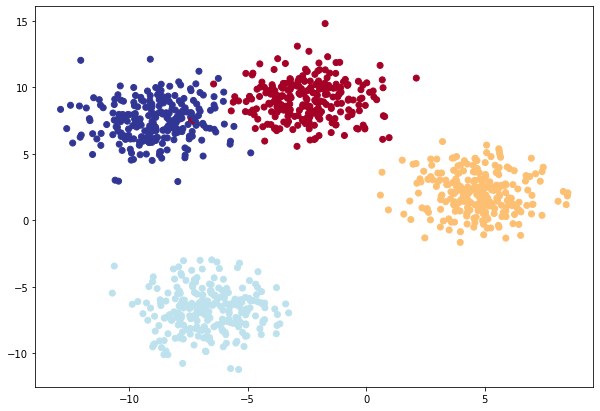

In [4]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

# Create model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
class MultiClassModel(torch.nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(in_features=input_features, out_features=hidden_units),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

In [7]:
model = MultiClassModel(input_features=n_features, output_features=n_classes, hidden_units=8).to(device)
model

MultiLabelModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Creating Loss Function & Optimizer

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

lr = 0.1
optimizer = torch.optim.SGD(lr=lr, params=model.parameters())

# Making predictions and Building a training loop

Just like in the binary classification problem, we need to convert the logits (output of our model) to predictions.

In [9]:
model.eval()

with torch.inference_mode():
  meaningless_preds = model(X_test.to(device))

In [10]:
# logits
meaningless_preds[:10]

tensor([[-4.1615e-01,  1.7998e-01, -1.9534e-01,  1.7753e-01],
        [-5.7715e-01, -3.3333e-01, -2.2039e-01,  1.8327e-01],
        [-9.8767e-01, -1.7184e-04,  1.0308e-01, -2.3825e-01],
        [-4.9977e-01,  1.9660e-01, -1.5367e-01,  1.2123e-01],
        [-2.7986e-01,  7.0078e-02, -2.6387e-01,  2.5954e-01],
        [-6.2979e-01, -4.1351e-01, -2.1074e-01,  1.6518e-01],
        [-1.1791e+00,  1.3558e-01,  2.6413e-01, -3.4103e-01],
        [-3.7421e-01, -5.1091e-02, -2.5160e-01,  2.3893e-01],
        [-7.7923e-01, -2.2195e-02,  8.5188e-02, -1.0415e-01],
        [-3.3670e-01, -2.9867e-03, -2.5647e-01,  2.4709e-01]], device='cuda:0')

In [11]:
# Prediction probabilities
# meaningless_pred_probs = torch.softmax(meaningless_preds)

Why does this error happen? Because of the dimensions! We want to apply the softmax function across rows!

In [12]:
# Predicted probabilities
meaningless_pred_probs = torch.softmax(meaningless_preds, dim=1)
meaningless_pred_probs[:10]

tensor([[0.1703, 0.3091, 0.2123, 0.3083],
        [0.1711, 0.2184, 0.2445, 0.3660],
        [0.1139, 0.3059, 0.3391, 0.2411],
        [0.1592, 0.3195, 0.2251, 0.2963],
        [0.1942, 0.2755, 0.1973, 0.3330],
        [0.1673, 0.2077, 0.2544, 0.3705],
        [0.0887, 0.3304, 0.3757, 0.2051],
        [0.1866, 0.2578, 0.2110, 0.3446],
        [0.1339, 0.2854, 0.3178, 0.2630],
        [0.1897, 0.2648, 0.2055, 0.3400]], device='cuda:0')

Notice that now, all rows sum up to one, so our rows have been correctly converted into probabilities

In [13]:
torch.sum(meaningless_pred_probs, dim=1)[:10]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

In [14]:
# Predictions
meaningless_pred_labels = torch.argmax(meaningless_pred_probs, dim=1)
meaningless_pred_labels[:10]

tensor([1, 3, 2, 1, 3, 3, 2, 3, 2, 3], device='cuda:0')

Notice that this is selecting the class with the highest probability (see predicted probabilities matrix above!). Also note that the prediction has the same shape as our labels when we use this process!

In [15]:
meaningless_pred_labels.shape, y_test.shape

(torch.Size([200]), torch.Size([200]))

# Training / Tesing loop

First, we need an accuracy function. We will implement the same accuracy function as we did in the binary classification dataset.

In [16]:
def accuracy_fn(y_true, y_pred):
  # torch.eq is torch equals, its like doing y_true == y_pred
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct * 100 / len(y_true)
  return acc

In [17]:
X_train.dtype

torch.float32

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

epoch_counts = []
acc_train_loss = []
acc_test_loss  = []
acc_train_acc  = []
acc_test_acc   = []

for epoch in range(1, epochs+1):
  model.train()

  X_train, y_train = X_train.to(device), y_train.type(torch.LongTensor).to(device)
  X_test, y_test = X_test.to(device), y_test.type(torch.LongTensor).to(device)

  # Forward pass:
  train_logits = model(X_train)
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

  # Loss (we are setting the type to Long because the loss implemented needs it)
  train_loss = loss_fn(train_logits, y_train)
  train_acc  = accuracy_fn(y_train, train_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backprop
  train_loss.backward()

  # Optimizer step
  optimizer.step()

  if epoch % 10 == 0:
    model.eval()

    with torch.inference_mode():
      test_logits = model(X_test)
      test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # (we are setting the type to Long because the loss implemented needs it)
      test_loss  = loss_fn(test_logits, y_test)
      test_acc   = accuracy_fn(y_test, test_preds)

      epoch_counts.append(epoch)
      acc_train_loss.append(train_loss)
      acc_test_loss.append(test_loss)
      acc_train_acc.append(train_acc)
      acc_test_acc.append(test_acc)

      print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc.: {train_acc} | Test Loss: {test_loss} | Test Acc.: {test_acc}")


Epoch: 10 | Train Loss: 0.47468647360801697 | Train Acc.: 93.625 | Test Loss: 0.4278794825077057 | Test Acc.: 97.5
Epoch: 20 | Train Loss: 0.24830050766468048 | Train Acc.: 98.5 | Test Loss: 0.21980135142803192 | Test Acc.: 100.0
Epoch: 30 | Train Loss: 0.1308063566684723 | Train Acc.: 99.125 | Test Loss: 0.11421403288841248 | Test Acc.: 99.5
Epoch: 40 | Train Loss: 0.08320876210927963 | Train Acc.: 99.25 | Test Loss: 0.07172035425901413 | Test Acc.: 99.5
Epoch: 50 | Train Loss: 0.06193966418504715 | Train Acc.: 99.25 | Test Loss: 0.05192677676677704 | Test Acc.: 99.5
Epoch: 60 | Train Loss: 0.05056716874241829 | Train Acc.: 99.25 | Test Loss: 0.04108322039246559 | Test Acc.: 99.5
Epoch: 70 | Train Loss: 0.04374684765934944 | Train Acc.: 99.25 | Test Loss: 0.034407585859298706 | Test Acc.: 99.5
Epoch: 80 | Train Loss: 0.03937840089201927 | Train Acc.: 99.25 | Test Loss: 0.030049212276935577 | Test Acc.: 99.5
Epoch: 90 | Train Loss: 0.036389946937561035 | Train Acc.: 99.25 | Test Loss: 

## Make predictions with model

In [20]:
model.eval()
with torch.inference_mode():
  logits = model(X_test)

logits[:5]

tensor([[-3.1672,  5.2418, -0.7479, -4.1299],
        [ 0.4937, -9.5548, -3.0251,  5.6251],
        [-2.8773, -1.2637,  5.3562, -6.2257],
        [-2.5665,  4.2269, -0.4867, -2.7173],
        [ 3.2038, -3.6790, -1.7692, -2.4741]], device='cuda:0')

In [21]:
preds = torch.softmax(logits, dim=1).argmax(dim=1)
preds[:5], y_test[:5]

(tensor([1, 3, 2, 1, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

In [22]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

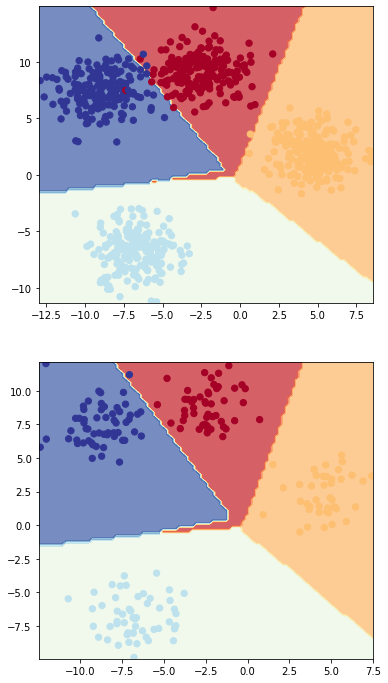

In [28]:
with torch.inference_mode():
  plt.figure(figsize=(6, 12))
  plt.subplot(2, 1, 1)
  plot_decision_boundary(model, X_train, y_train)
  plt.subplot(2, 1, 2)
  plot_decision_boundary(model, X_test, y_test)

# Would removing the non-linearities change the output?

In [29]:
class MultiClassLinearModel(torch.nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(in_features=input_features, out_features=hidden_units),
        # torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

In [30]:
model = MultiClassLinearModel(input_features=n_features, output_features=n_classes, hidden_units=8).to(device)
model

MultiClassLinearModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()

lr = 0.1
optimizer = torch.optim.SGD(lr=lr, params=model.parameters())

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

epoch_counts = []
acc_train_loss = []
acc_test_loss  = []
acc_train_acc  = []
acc_test_acc   = []

for epoch in range(1, epochs+1):
  model.train()

  X_train, y_train = X_train.to(device), y_train.type(torch.LongTensor).to(device)
  X_test, y_test = X_test.to(device), y_test.type(torch.LongTensor).to(device)

  # Forward pass:
  train_logits = model(X_train)
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

  # Loss (we are setting the type to Long because the loss implemented needs it)
  train_loss = loss_fn(train_logits, y_train)
  train_acc  = accuracy_fn(y_train, train_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backprop
  train_loss.backward()

  # Optimizer step
  optimizer.step()

  if epoch % 10 == 0:
    model.eval()

    with torch.inference_mode():
      test_logits = model(X_test)
      test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # (we are setting the type to Long because the loss implemented needs it)
      test_loss  = loss_fn(test_logits, y_test)
      test_acc   = accuracy_fn(y_test, test_preds)

      epoch_counts.append(epoch)
      acc_train_loss.append(train_loss)
      acc_test_loss.append(test_loss)
      acc_train_acc.append(train_acc)
      acc_test_acc.append(test_acc)

      print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc.: {train_acc} | Test Loss: {test_loss} | Test Acc.: {test_acc}")


Epoch: 10 | Train Loss: 0.15716296434402466 | Train Acc.: 99.125 | Test Loss: 0.1418735831975937 | Test Acc.: 99.0
Epoch: 20 | Train Loss: 0.08403276652097702 | Train Acc.: 99.125 | Test Loss: 0.0754237249493599 | Test Acc.: 99.5
Epoch: 30 | Train Loss: 0.06068568676710129 | Train Acc.: 99.125 | Test Loss: 0.05276947468519211 | Test Acc.: 99.5
Epoch: 40 | Train Loss: 0.04969831556081772 | Train Acc.: 99.0 | Test Loss: 0.04177199676632881 | Test Acc.: 99.5
Epoch: 50 | Train Loss: 0.043428968638181686 | Train Acc.: 99.0 | Test Loss: 0.03535689041018486 | Test Acc.: 99.5
Epoch: 60 | Train Loss: 0.039420273154973984 | Train Acc.: 99.0 | Test Loss: 0.03117363154888153 | Test Acc.: 99.5
Epoch: 70 | Train Loss: 0.03665785491466522 | Train Acc.: 99.0 | Test Loss: 0.028234833851456642 | Test Acc.: 99.5
Epoch: 80 | Train Loss: 0.03465087339282036 | Train Acc.: 99.0 | Test Loss: 0.02605762891471386 | Test Acc.: 99.5
Epoch: 90 | Train Loss: 0.033134184777736664 | Train Acc.: 99.125 | Test Loss: 0.

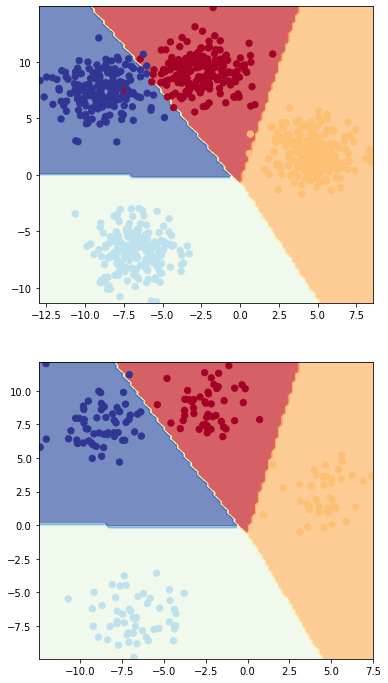

In [33]:
with torch.inference_mode():
  plt.figure(figsize=(6, 12))
  plt.subplot(2, 1, 1)
  plot_decision_boundary(model, X_train, y_train)
  plt.subplot(2, 1, 2)
  plot_decision_boundary(model, X_test, y_test)

### Why is this happening? Shouldn't a non-linear model get better results because it can adapt to more complex data?

The keyword here is that the data is **linearly separable**. We will say that a group of sets of points are linearly separable if there exists a set of lines in the plane that can separate the points into independent regions, so that points from each set fall into an individual region of the vector space.

According to this definition, our dataset is not strictly linearly separable, but it would be if it wasn't for a few points (which are the points in which our model is messing up). So we can approximate our data as linearly separable.

# Alternative Metrics for this classification problem

A few metrics that may be of interest for a classification problem are listed below:

* Accuracy - Out of 100 samples, how many am I getting right? Good for balanced data, not the best for imbalanced data.
* Precision - Higher precision leads to less False Positives
* Recall - Higher recall leads to less False Negatives
* F1 Score - The geometric mean of Precision and Recall. Good overall for classification.

## Using torchmetrics

The torchmetrics library implements a lot of the metrics we will generally use in practice. You can check the documentation [here](https://pytorch-lightning.readthedocs.io/en/stable/ecosystem/metrics.html). The library also implements a Metric class that can be subclassed by you when you create your own metrics.

In [34]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 37.7 MB/s eta 0:00:00


In [35]:
import torchmetrics

In [37]:
accuracy = torchmetrics.Accuracy("multiclass", num_classes=4).to(device)

In [38]:
accuracy(test_preds, y_test)

tensor(0.9950, device='cuda:0')